# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
survey_fields = [
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

correlations[survey_fields].sort_values(ascending=False)

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
saf_t_11      0.313810
N_t           0.291463
rr_s          0.232199
eng_s_11      0.213822
aca_tot_11    0.190966
com_s_11      0.187370
aca_t_11      0.132348
saf_p_11      0.122913
eng_tot_11    0.100102
com_t_11      0.082419
com_tot_11    0.077310
rr_p          0.047925
eng_t_11      0.036906
aca_p_11      0.035155
eng_p_11      0.020254
rr_t         -0.023386
com_p_11     -0.115073
Name: sat_score, dtype: float64

Text(0, 0.5, 'Correlations')

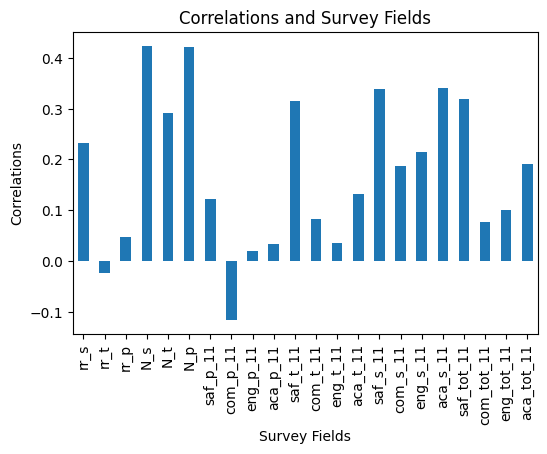

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
correlations[survey_fields].plot(kind='bar', title='Correlations and Survey Fields')
plt.xlabel('Survey Fields')
plt.ylabel('Correlations')

Based on the correlation chart, we can see that there is a strong correlation between the safety of teachers/students("saf_t_11", "saf_s_11" and "saf_total_1" and the SAT score.

# Exploring Safety and SAT Scores
In this section, I will create a scatter plot of the safety of students (saf_s_11) column and the sat_score column in the combined dataframe.

I will also compute the average safety score for each borough in New York

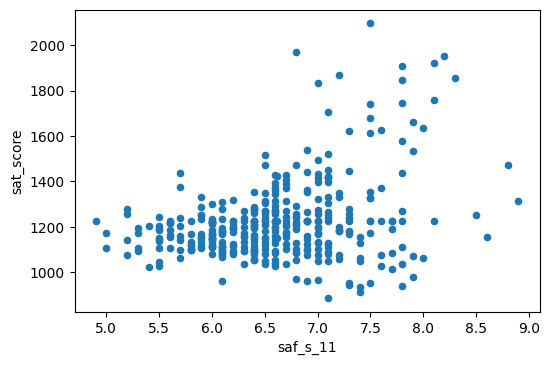

In [13]:
combined.plot.scatter(x='saf_s_11', y='sat_score')
plt.show()

There is a positive correlation between the sat_score and saf_s_11 columns however, it is not a strong correlation.

## Average safetry score for each borough


In [14]:
avg_safety_boro = combined.groupby('boro').agg(numpy.mean)
borough_safety = avg_safety_boro['saf_s_11'].sort_values()
borough_safety

boro
Brooklyn         6.370755
Staten Island    6.530000
Bronx            6.606577
Queens           6.721875
Manhattan        6.831370
Name: saf_s_11, dtype: float64

### Conclusion
Manhattan has the highest safety score among the five boroughs while Brooklyn has the lowest safety score

# Exploring Race and SAT Scores
In this section, I will plot out the correlations between the race columns (white_per, asian_per, black_per, hispanic_per) and the sat_score column to determine whether there are any racial differences in SAT performance.

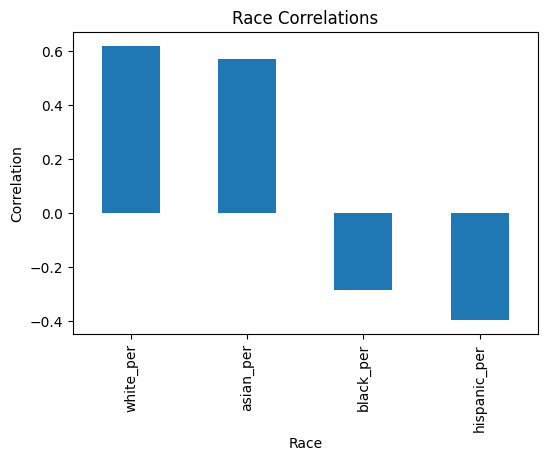

In [15]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations[race_cols].plot(kind='bar', title='Race Correlations')
plt.xlabel('Race')
plt.ylabel('Correlation')
plt.show()

Observations: Schools with high white and asian percentages have strong positive correlations with the sat_score while schools with high black and hispanic percentages have negative correlations with sat_scores

### Exploring schools with low SAT scores and Hispanic %

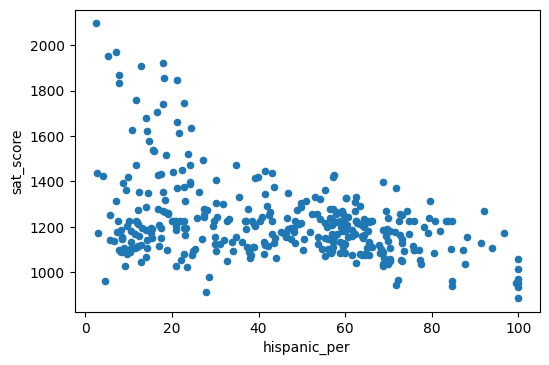

In [16]:
combined.plot.scatter('hispanic_per', 'sat_score')
plt.show()

### Observation
There is a weak negative correlaction with hispanic_per and sat_score. The less hispanics, the higher the SAT score. However, there are a few schools with a low hispanic_per that have lower SAT scores.

## Schools with hispanic_per greater than 95%

In [17]:
hispanic_per_95 = combined[combined['hispanic_per'] > 95]
hispanic_per_95[['SCHOOL NAME', 'sat_score', 'hispanic_per']].head()

,SCHOOL NAME,sat_score,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,99.8


## Schools with  hispanic_per < 10% and average SAT score > 1800

In [18]:
hispanic_10_1800 = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
hispanic_10_1800[['SCHOOL NAME', 'sat_score', 'hispanic_per']]

,SCHOOL NAME,sat_score,hispanic_per
37,STUYVESANT HIGH SCHOOL,2096.0,2.4
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,7.9
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,5.3


# Exploring Gender and SAT Scores

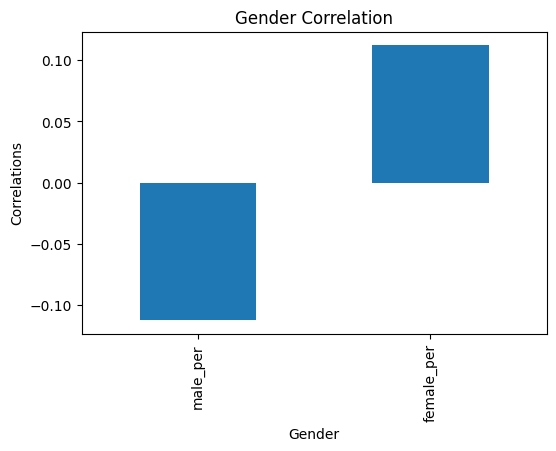

In [19]:
gender_cols = ['male_per', 'female_per']
correlations[gender_cols].plot(kind='bar', title='Gender Correlation')
plt.xlabel('Gender')
plt.ylabel('Correlations')
plt.show()

## Observation
There is a negative correlation between sat_socres and  schools with high male percentages while there is a positive correlation between sat_scores and schools with high female percentages

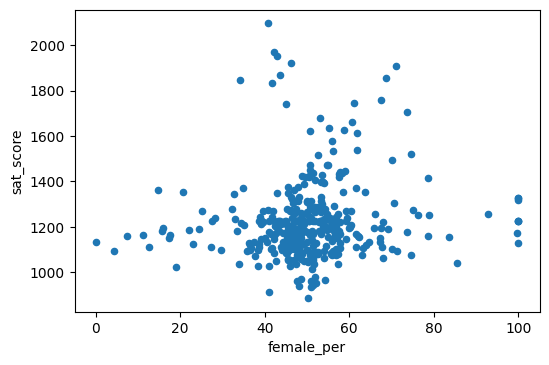

In [20]:
# investigating schools with high SAT scores and high female_per 
combined.plot.scatter('female_per', 'sat_score')
plt.show()

There is a weak positive correlation. There are a few schools with a female_per over 60% that have an average SAT score of over 1700

In [21]:
# schools with female_per greater than 60% and average SAT score greater than 1700
female_per_60 = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
female_per_60[['SCHOOL NAME', 'sat_score', 'female_per']].sort_values(by='sat_score', ascending=False)

,SCHOOL NAME,sat_score,female_per
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,71.1
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,67.5
60,BEACON HIGH SCHOOL,1744.0,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,73.6


# Exploring AP Scores vs SAT Scores
In this section, I will explore the total number of students who took the AP exams in each high school and analyze how it correlates with the average SAT Score of a school 

In [27]:
# create a column for the percentage of AP Test takers from the total enrollment column
combined['ap_per'] = round((combined['AP Test Takers '] / combined['total_enrollment']) * 100, 2)
combined['ap_per']

0      30.58
1       9.90
2       3.18
3      35.16
4      15.81
       ...  
358     7.76
359    29.73
360    19.10
361     2.66
362     7.36
Name: ap_per, Length: 363, dtype: float64

0.05717292460813365


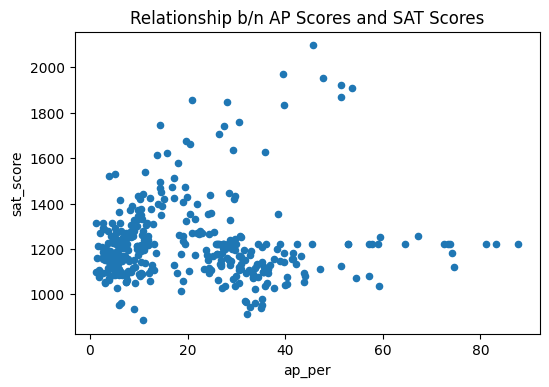

In [30]:
# relationship between AP scores and SAT Score
print(combined['ap_per'].corr(combined['sat_score']))
combined.plot.scatter('ap_per', 'sat_score', title='Relationship b/n AP Scores and SAT Scores')
plt.show()

## Observation
Theres is a very weak yet positive correlation between the percentage of AP Test Takers and avereage SAT Scores of schools in New York

## Things To Do
1. Determe whether there's a correlation between class size and SAT scores
2. Figure out which neighborhoods have the best schools
3. If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools
4. Investigate the differences between parent, teacher, and student responses to surveys

